In [6]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        # txt 파일의 헤더(id document label)는 제외하기
        data = data[1:]
    return data

train_data = read_data('labeling_train.txt')
test_data= read_data('labeling_test.txt')

print(len(train_data))
print(len(test_data))

2292
500


In [7]:
# Konlpy 라이브러리를 이용해서 형태소 분석 및 품사 태깅한다.
# Okt(Open Korea Text)클래스를 이용.

from konlpy.tag import Okt

okt = Okt()
print(okt.pos(u'이 밤 그날의 반딧불을 당신의 참 가까이 보낼게요.'))


[('이', 'Noun'), ('밤', 'Noun'), ('그날', 'Noun'), ('의', 'Josa'), ('반딧불', 'Noun'), ('을', 'Josa'), ('당신', 'Noun'), ('의', 'Josa'), ('참', 'Verb'), ('가까이', 'Noun'), ('보낼게요', 'Verb'), ('.', 'Punctuation')]


In [8]:
# test.txt와 train.txt에서 형태소 분석을  통해서 품사를 태깅하는 작업 실시
# 한 번 태깅을 마친 후에는 json 파일에 저장한다. (반복 작업 방지)
import json
import os
from pprint import pprint

def tokenize(doc):
    # norm은 정규화, stem은 근어로 표시하기를 나타냄
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

if os.path.isfile('train_docs.json'):
    with open('train_docs.json', encoding='utf-8') as f:
        train_docs = json.load(f)
    with open('test_docs.json', encoding='utf-8') as f:
        test_docs = json.load(f)
else:
    train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
    test_docs = [(tokenize(row[1]), row[2]) for row in test_data]
    # JSON 파일로 저장
    with open('train_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('test_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")
        
# 보기 좋게 출력하기 위하여 pprint 라이브러리 사용
pprint(train_docs[0])

(['셧다운/Noun',
  '제/Noun',
  '는/Josa',
  '시대/Noun',
  '착오/Noun',
  '적/Suffix',
  '발상/Noun',
  '이라고/Josa',
  '생각/Noun',
  '하다/Verb',
  './Punctuation'],
 '0')


In [9]:
# 분석한 데이터의 토큰(문자열 분석을 위한 작은 단위)의 갯수를 확인한다.


tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

50804


In [10]:
# nltk 라이브러리를 통해서 전처리실시.
# Text 클래스는 문서를 편리하게 탐색할 수 있는 다양한 기능을 제공
# vocab().most_common 메서드를 이용하여 데이터에서 가장 자주 사용되는 단어를 추출
import nltk
text = nltk.Text(tokens, name='NMSC')

# 전체 토큰의 개수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))            

# 출현 빈도가 높은 상위 토큰 10개
pprint(text.vocab().most_common(10))

50804
4528
[('하다/Verb', 2384),
 ('./Punctuation', 1441),
 ('을/Josa', 1296),
 ('이/Josa', 1234),
 ('의/Josa', 1062),
 ('것/Noun', 880),
 ('를/Josa', 856),
 ('에/Josa', 851),
 ('있다/Adjective', 827),
 ('가/Josa', 750)]


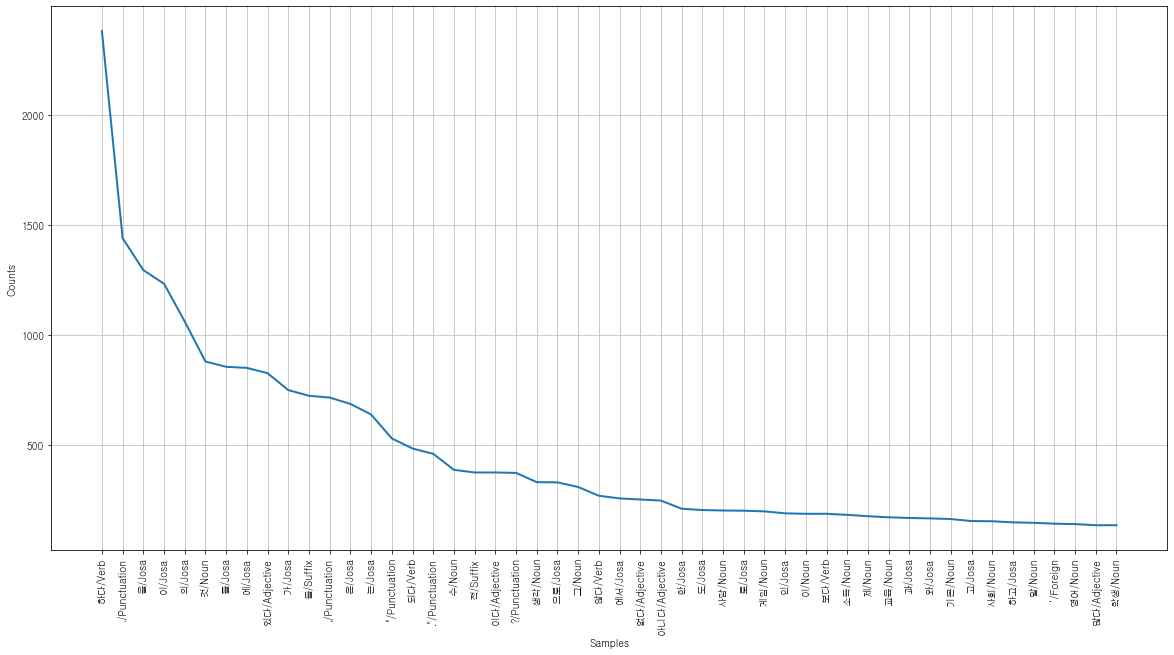

In [11]:
# 자주 나오는 단어 50개를 matplotlib 라이브러리를 통해서 그래프로 나타낸다.

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

In [12]:
# 자주 사용되는 토큰을 사용해서 데이터를 벡터화를 시킴.
# 우리의 중복을 제외한 토큰수는 4528 이므로 그 중 4500개를 써보도록 하겠다.

selected_words = [f[0] for f in text.vocab().most_common(4500)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

In [13]:
import numpy as np

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [14]:
# 모델 생성을 위한 패키지 선언
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [15]:
from tensorflow.keras import utils

In [16]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(4500,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(258, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='softmax'))



model.compile(optimizer='adam', 
              metrics=['accuracy'],
             loss='sparse_categorical_crossentropy')

model.fit(x_train, y_train, epochs=15, batch_size=256)
results = model.evaluate(x_test, y_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/15
2292/2292 [==============================] - 1s 296us/sample - loss: 3.9084 - acc: 0.4607
Epoch 2/15
2292/2292 [==============================] - 0s 101us/sample - loss: 2.2864 - acc: 0.5541
Epoch 3/15
2292/2292 [==============================] - 0s 97us/sample - loss: 1.5046 - acc: 0.4258
Epoch 4/15
2292/2292 [==============================] - 0s 93us/sample - loss: 1.0907 - acc: 0.5541
Epoch 5/15
2292/2292 [==============================] - 0s 101us/sample - loss: 0.9692 - acc: 0.5541
Epoch 6/15
2292/2292 [==============================] - 0s 103us/sample - loss: 0.9133 - acc: 0.5541
Epoch 7/15
2292/2292 [==============================] - 0s 116us/sample - loss: 0.8388 - acc: 0.5886
Epoch 8/15
2292/2292 [==============================] - 0s 91us/sample - loss: 0.7170 - acc: 0.6750
Epoch 9/15
2292/2292 [==============================] - 0s 104us/sample - los

In [17]:
# 최종 정확도
results

[3.857146490097046, 0.412]

In [18]:
def predict_pos_neg(opinion):
    token = tokenize(opinion)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = model.predict(data)
    max_index=0
    max_value=-1
    index=0
    for prob in score[0]:
        if max_value< prob:
            max_value=prob
            max_index=index
        index+=1
    if max_index==0:
        print("[{}]는 {:.2f}% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^\n".format(opinion, max_value * 100))
    elif max_index==1:
        print("[{}]는 {:.2f}% 확률로 중립 리뷰이지 않을까 추측해봅니다.^^\n".format(opinion, max_value * 100))
    elif max_index==2:
        print("[{}]는 {:.2f}% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^\n".format(opinion, max_value * 100))

In [19]:
predict_pos_neg("내일 공강이다.")
predict_pos_neg("동의합니다.")
predict_pos_neg("좋아요.")
predict_pos_neg("맞습니다.")
predict_pos_neg("반대합니다")
predict_pos_neg("난 너무 좋아!")
predict_pos_neg("그건 좀 아닌거같아")
predict_pos_neg("난 중립이야")
predict_pos_neg("난 노트북이야")
predict_pos_neg("장고는 정말 쓰레기같은 프레임워크야")
predict_pos_neg("장고는 안좋은 프레임워크야")

[내일 공강이다.]는 46.37% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^

[동의합니다.]는 68.25% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[좋아요.]는 67.23% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[맞습니다.]는 87.01% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[반대합니다]는 89.94% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^

[난 너무 좋아!]는 51.55% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^

[그건 좀 아닌거같아]는 51.40% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[난 중립이야]는 83.31% 확률로 중립 리뷰이지 않을까 추측해봅니다.^^

[난 노트북이야]는 83.31% 확률로 중립 리뷰이지 않을까 추측해봅니다.^^

[장고는 정말 쓰레기같은 프레임워크야]는 61.00% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[장고는 안좋은 프레임워크야]는 52.45% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^



In [21]:
#모델 저장하기
from tensorflow.keras.models import load_model


In [ ]:
#모델 저장하기
model.save('meeting_mlp_model.h5')

In [139]:
#모델 아키텍처를 json 형식으로 저장하기
model.save_weights('meeting_wegihts')


In [22]:
model = load_model('meeting_mlp_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [23]:
predict_pos_neg("내일 공강이다.")
predict_pos_neg("동의합니다.")
predict_pos_neg("좋아요.")
predict_pos_neg("맞습니다.")
predict_pos_neg("반대합니다")
predict_pos_neg("난 너무 좋아!")
predict_pos_neg("그건 좀 아닌거같아")
predict_pos_neg("난 중립이야")
predict_pos_neg("난 노트북이야")
predict_pos_neg("장고는 정말 쓰레기같은 프레임워크야")
predict_pos_neg("장고는 안좋은 프레임워크야")

[내일 공강이다.]는 51.53% 확률로 중립 리뷰이지 않을까 추측해봅니다.^^

[동의합니다.]는 58.26% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[좋아요.]는 37.74% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[맞습니다.]는 87.74% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[반대합니다]는 91.65% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^

[난 너무 좋아!]는 46.37% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[그건 좀 아닌거같아]는 52.79% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^

[난 중립이야]는 69.34% 확률로 중립 리뷰이지 않을까 추측해봅니다.^^

[난 노트북이야]는 69.34% 확률로 중립 리뷰이지 않을까 추측해봅니다.^^

[장고는 정말 쓰레기같은 프레임워크야]는 66.72% 확률로 중립 리뷰이지 않을까 추측해봅니다.^^

[장고는 안좋은 프레임워크야]는 43.84% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^

